In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from hetero.algo import align_binary_labels, group
from hetero.config import (
    DEFAULT_GROUP_REWARD_COEFF_OVERRIDE,
    DTYPE,
    AlgoConfig,
    DataGenConfig,
    DimConfig,
    GroupingConfig,
)
from hetero.datagen import generate_data_from_config
from hetero.policies import AllPosPolicy, AlternativePolicy, SoftmaxPolicy
from hetero.utils import LabelPartitioner, remove_outlier

=====================================================================================================

In [2]:
# Linear setting hence no expansion settings.
# N=100 and N=40.

data_config = DataGenConfig(
    num_trajectories=100,
    num_time_steps=30,
    group_reward_coeff_override=np.array(
        [
            [-2, 2, 2, -2],
            [2, -2, -2, 2],
        ],
        dtype=DTYPE,
    ),
    action_reward_coeff=[-1, 1],
    basis_expansion_method="LEGENDRE",
    transformation_method="NORMCDF",
    noise_type="STUDENT",
    noise_student_degree=4,
)
data = generate_data_from_config(data_config)
pi_eval = AlternativePolicy(data_config.NUM_ACTIONS)
discount = 0.6

In [3]:
from hetero.algo import beta_from_linreg
from hetero.utils import action_feature_prod

Z = action_feature_prod(data.actions, data.current_features)
pi_eval_actions = pi_eval.action(data.next_features)
U = action_feature_prod(pi_eval_actions, data.next_features)
print(Z.shape, U.shape)
beta = beta_from_linreg(data, Z, U, discount)
print(beta.shape)

(6000, 8) (6000, 8)
(200, 8)


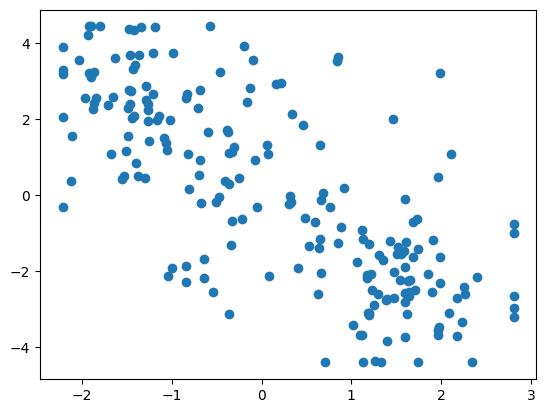

In [4]:
# Trajectory wise regression betas, only for demo.

init_beta = remove_outlier(beta, 2, 98)
plt.scatter(init_beta[:, 0], init_beta[:, 1])

In [5]:
# Compute trajectory wise betas with optimizer

from hetero.algo import BetaOptimizer, MCPImpl

base_config = dict(
    discount=discount,
    max_num_iters=10,
    should_remove_outlier=True,
    outlier_lower_perc=2,
    outlier_upper_perc=98,
    nu_coeff=1e-4,
    delta_coeff=1e-4,
    use_group_wise_regression_init=True,
)

lam = 1.0
algo_config = AlgoConfig(lam=lam, **base_config)
impl = MCPImpl(data.N(), algo_config)
beta_opt = BetaOptimizer(data, algo_config, pi_eval, impl)
beta_optimized = beta_opt.compute()

beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=19499, num_below=401
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=19589, num_below=311
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=19297, num_below=603
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=19117, num_below=783
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=18739, num_below=1161
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=18533, num_below=1367
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=18374, num_below=1526
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=18259, num_below=1641
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=18167, num_below=1733
beta_solver, min eigen of left matrix = (0.03750284+0j)
MCPImpl: num_above=18083, num_below=1817


In [6]:
import collections
import importlib

import hetero.algo as algo_mod
import hetero.config as config_mod
import hetero.offline_rl as offline_rl_mod
import hetero.utils as utils_mod

algo_mod = importlib.reload(algo_mod)
config_mod = importlib.reload(config_mod)
offline_rl_mod = importlib.reload(offline_rl_mod)
utils_mod = importlib.reload(utils_mod)

learned_labels = algo_mod.group(
    beta_optimized, config_mod.GroupingConfig(num_clusters=2)
)

collections.Counter(learned_labels)

rl_split_pols = offline_rl_mod.split_sars_data_for_rl(data, learned_labels)
RL_PARAMS = offline_rl_mod.ActorCriticLearnerParams(
    lr=2e-2, decay=1e-4, grad_norm_clip=1000
)

kmeans center = [[ 1.20457337 -1.93433667 -1.86857071  3.51112914  3.38777482 -0.88379249
  -2.25586144  2.93658091]
 [-0.95487846  2.08272912  1.7731891  -3.63859281 -3.61475022  0.99805776
   2.41975019 -3.0944973 ]] and inertia = 1543.312320087659


In [8]:
cluster = 0
rl_pol = rl_split_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_0 = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)
acl_0.learn()
print(f"MEAN_Y_FINAL={acl_0.eval()} and #SAMPLES={acl_0.sample_pi.num_samples}")

Perfoming RL for cluster=0 with 3000 records
  * At actor-learn step 0, g_norm=1266.158(CLIP@1000), y=3369.622
  * At actor-learn step 1, g_norm=1263.776(CLIP@1000), y=3426.107
  * At actor-learn step 2, g_norm=1259.518(CLIP@1000), y=3465.969
  * At actor-learn step 3, g_norm=1254.479(CLIP@1000), y=3498.437
  * At actor-learn step 3, stopped at y=3498.437, prev_y=3465.969, relative_error=0.009
* At alter step 0, diff_norm=0.125, cur_norm=0.014, relative_error=5.171
  * At actor-learn step 0, g_norm=1250.998(CLIP@1000), y=3741.444
  * At actor-learn step 1, g_norm=1236.860(CLIP@1000), y=3797.624
  * At actor-learn step 2, g_norm=1224.429(CLIP@1000), y=3837.133
  * At actor-learn step 3, g_norm=1212.828(CLIP@1000), y=3869.234
  * At actor-learn step 3, stopped at y=3869.234, prev_y=3837.133, relative_error=0.008
* At alter step 1, diff_norm=0.127, cur_norm=0.128, relative_error=0.919
  * At actor-learn step 0, g_norm=1204.390(CLIP@1000), y=4110.191
  * At actor-learn step 1, g_norm=1179.

In [9]:
cluster = 1
rl_pol = rl_split_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_1 = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)
acl_1.learn()
print(f"MEAN_Y_FINAL={acl_1.eval()} and #SAMPLES={acl_1.sample_pi.num_samples}")

Perfoming RL for cluster=1 with 3000 records
  * At actor-learn step 0, g_norm=1381.243(CLIP@1000), y=-2993.812
  * At actor-learn step 1, g_norm=1379.461(CLIP@1000), y=-2937.332
  * At actor-learn step 2, g_norm=1375.763(CLIP@1000), y=-2897.459
  * At actor-learn step 3, g_norm=1371.259(CLIP@1000), y=-2864.970
  * At actor-learn step 4, g_norm=1366.294(CLIP@1000), y=-2836.898
  * At actor-learn step 4, stopped at y=-2836.898, prev_y=-2864.970, relative_error=0.010
* At alter step 0, diff_norm=0.133, cur_norm=0.014, relative_error=5.502
  * At actor-learn step 0, g_norm=1358.744(CLIP@1000), y=-2561.904
  * At actor-learn step 1, g_norm=1344.076(CLIP@1000), y=-2505.687
  * At actor-learn step 2, g_norm=1331.400(CLIP@1000), y=-2466.141
  * At actor-learn step 3, g_norm=1319.675(CLIP@1000), y=-2433.997
  * At actor-learn step 4, g_norm=1308.549(CLIP@1000), y=-2406.279
  * At actor-learn step 5, g_norm=1297.851(CLIP@1000), y=-2381.588
  * At actor-learn step 6, g_norm=1287.486(CLIP@1000), 

In [10]:
rl_pols_comb = offline_rl_mod.split_sars_data_for_rl(data, [0] * data.NT())
RL_PARAMS = offline_rl_mod.ActorCriticLearnerParams(
    lr=1e-2, decay=1e-4, grad_norm_clip=1000
)

cluster = 0
rl_pol = rl_pols_comb[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_comb = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)
acl_comb.learn()
print(
    f"MEAN_Y_FINAL_COMB={acl_comb.eval()} and #SAMPLES={acl_comb.sample_pi.num_samples}"
)

from hetero.policies import SoftmaxPolicy

print(f"MEAN_Y_FINAL_0={acl_0.eval()} and #SAMPLES={acl_0.sample_pi.num_samples}")
print(f"MEAN_Y_FINAL_1={acl_1.eval()} and #SAMPLES={acl_1.sample_pi.num_samples}")
print(
    f"MEAN_Y_FINAL_COMB={acl_comb.eval()} and #SAMPLES={acl_comb.sample_pi.num_samples}"
)

for i in range(2):
    print(
        f"Combined pol eval on cluser {i} =",
        rl_split_pols[i].fit_then_eval(
            SoftmaxPolicy(acl_comb.weights()), algo_config.discount
        ),
    )

Perfoming RL for cluster=0 with 6000 records
  * At actor-learn step 0, g_norm=58.355, y=283.660
  * At actor-learn step 1, g_norm=58.351, y=285.015
  * At actor-learn step 1, stopped at y=285.015, prev_y=283.660, relative_error=0.005
* At alter step 0, diff_norm=0.048, cur_norm=0.014, relative_error=2.003
  * At actor-learn step 0, g_norm=58.399, y=289.203
  * At actor-learn step 1, g_norm=58.381, y=290.560
  * At actor-learn step 1, stopped at y=290.560, prev_y=289.203, relative_error=0.005
* At alter step 1, diff_norm=0.048, cur_norm=0.058, relative_error=0.708
  * At actor-learn step 0, g_norm=58.420, y=294.761
  * At actor-learn step 1, g_norm=58.387, y=296.119
  * At actor-learn step 1, stopped at y=296.119, prev_y=294.761, relative_error=0.005
* At alter step 2, diff_norm=0.048, cur_norm=0.106, relative_error=0.416
  * At actor-learn step 0, g_norm=58.417, y=300.332
  * At actor-learn step 1, g_norm=58.371, y=301.690
  * At actor-learn step 1, stopped at y=301.690, prev_y=300.33

  * At actor-learn step 1, stopped at y=591.087, prev_y=590.492, relative_error=0.001
* At alter step 70, diff_norm=0.043, cur_norm=3.253, relative_error=0.013
  * At actor-learn step 0, g_norm=28.083, y=592.972
  * At actor-learn step 1, g_norm=27.755, y=593.557
  * At actor-learn step 1, stopped at y=593.557, prev_y=592.972, relative_error=0.001
* At alter step 71, diff_norm=0.043, cur_norm=3.295, relative_error=0.013
  * At actor-learn step 0, g_norm=27.547, y=595.411
  * At actor-learn step 1, g_norm=27.223, y=595.986
  * At actor-learn step 1, stopped at y=595.986, prev_y=595.411, relative_error=0.001
* At alter step 72, diff_norm=0.043, cur_norm=3.338, relative_error=0.013
  * At actor-learn step 0, g_norm=27.019, y=597.809
  * At actor-learn step 1, g_norm=26.701, y=598.374
  * At actor-learn step 1, stopped at y=598.374, prev_y=597.809, relative_error=0.001
* At alter step 73, diff_norm=0.043, cur_norm=3.380, relative_error=0.013
  * At actor-learn step 0, g_norm=26.501, y=600.

In [11]:
sample_0 = rl_split_pols[0].current_features[50, :]
print(sample_0)
learned_0 = SoftmaxPolicy(acl_0.weights())
learned_1 = SoftmaxPolicy(acl_1.weights())
learned_comb = SoftmaxPolicy(acl_comb.weights())
print("learned 0 applied to sample 0 =", learned_0.action(sample_0))
print("learned 1 applied to sample 0 =", learned_1.action(sample_0))
print("learned comb applied to sample 0 =", learned_comb.action(sample_0))

[0.01887669 0.43626896 1.         0.3222592 ]
learned 0 applied to sample 0 = [3.375687e-04 9.996624e-01]
learned 1 applied to sample 0 = [9.9967062e-01 3.2941453e-04]
learned comb applied to sample 0 = [0.03641494 0.963585  ]


In [12]:
sample_1 = rl_split_pols[1].current_features[50, :]
print(sample_1)
print("learned 0 applied to sample 1 =", learned_0.action(sample_1))
print("learned 1 applied to sample 1 =", learned_1.action(sample_1))
print("learned comb applied to sample 1 =", learned_comb.action(sample_1))

[0.9627869  0.44056582 0.9999904  0.32044348]
learned 0 applied to sample 1 = [4.4712897e-06 9.9999547e-01]
learned 1 applied to sample 1 = [9.9999547e-01 4.5605570e-06]
learned comb applied to sample 1 = [0.44975644 0.55024356]
